<a href="https://colab.research.google.com/github/larhs/dash/blob/master/plandemic_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from fastai.text import *
import pandas as pd
import numpy as np
from sklearn.feature_selection import chi2

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
from sklearn.model_selection import train_test_split

In [8]:
%cd "gdrive/My Drive/Manila/Bachelor-2-Master/ESADE/capstone"
!ls

/content/gdrive/My Drive/Manila/Bachelor-2-Master/ESADE/capstone
'20200508-164148_plandemic[1].xlsx'   nlp_EDA_v3.ipynb
 Extract_subtitles.ipynb	      nlp_model_training.ipynb
 Labelling.R			      pandemic_nlp_subs_clean.csv


In [10]:
filename = "pandemic_nlp_subs_clean.csv"
df = pd.read_csv(filename, index_col=0)

In [11]:
df.head()

,binary,text
0,0,hi today we're gonna talk about a concept very...
1,1,"2020, UT AS ALWAYS, ""THE STORY""\nCONTINUES AND..."
2,0,welcome to my scientifically formed sider look...
4,0,[] as it was here which I was born South Afri...
5,0,welcome to my scientifically formed sider look...


In [13]:
df_trn, df_val = train_test_split(df, stratify = df['binary'], test_size = 0.3, random_state=42)
df_trn.shape, df_val.shape

((177, 2), (77, 2))

In [14]:
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")

In [15]:
# Classifier model data
data_clas = TextClasDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "", vocab=data_lm.train_ds.vocab, bs=32)

In [16]:
# check out data
data_clas.show_batch()

text,target
xxbos xxunk pretty much everythg often i thk you do it yes like a little sgle xxunk xxunk so just i feel like go facet stop warriors best you can there 's good yeah how are you dog nobody is good i did n't i did not expect you see this that 's for sure surprised well let me put some fears aside we 're not here for what you,0
xxbos [ ] we 've covered how to spot a psychopath or sociopath before but we 've never gone this depth on the clical diagnosis behd them antisocial personality disorder welcome to the med circle series antisocial personality disorder psychopaths sociopaths how to spot them it 's just so great to sit down you i love talkg you sometimes we talk about some topics that i thk are really really,0
xxbos > > i ’m xxmaj jeff ezos . > > xxmaj what is your claim to fame ? > > i ’m the founder of xxmaj amazon.com . > > xxup narrator : xxmaj from the awardwng producers of “ \n xxmaj facebook xxmaj dilemma ” . > > est guy the world . > > xxup narrator : xxunk xxmaj amazon . > > xxmaj is xxmaj,0
xxbos > > xxup narrator : xxmaj tonight > > race to become an xxup a.i. \n superpower is on ... > > xxup narrator : politics of \n artificial telligence ... > > re will be \n a xxmaj chese tech sector there will be \n a xxmaj american tech sector . > > xxup narrator : new tech war . > > more data,0
xxbos xxup characteristics xxup and i xxup do xxup that xxup to xxup get a xxup point xxup across . xxup to xxup help xxup us xxup understand xxup our xxup xxunk xxup and xxup we \ ' xxup re xxup fighting xxup every xxup day xxup the xxup importance xxup of xxup never xxup xxunk xxup your xxup enemies . xxup it \ xxup 's xxup een a xxup,0


In [17]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [18]:
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,5.518666,4.668694,0.288940,01:35
1,5.036852,4.262319,0.316113,01:36
2,4.629392,3.940450,0.333275,01:37
3,4.370813,3.799770,0.343924,01:37
4,4.179133,3.730492,0.350902,01:37
5,4.103771,3.696926,0.353211,01:37
6,4.056867,3.674861,0.355575,01:37
7,4.081628,3.666145,0.355835,01:37
8,3.963944,3.663906,0.356238,01:37
9,3.989944,3.662565,0.356280,01:37


In [19]:
#save the language model encoder so that we can load it later in our classifier
learn.save_encoder("ft_enc_clean")

In [20]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, metrics=[accuracy])
learn.load_encoder('ft_enc_clean')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (177 items)
x: TextList
xxbos xxup that xxup empty xxup middle xxup seat . 
  xxup rian : i xxup agree . xxup rian : i xxup agree . 
  xxup steve : xxup they xxup said xxup we xxup will xxup not xxup steve : xxup they xxup said xxup we xxup will xxup not 
  xxup charge xxup people xxup for xxup that . xxup charge xxup people xxup for xxup that . 
  xxup let xxup ’s xxup ring xxup in xxup texas xxup congressman xxup let xxup ’s xxup ring xxup in xxup texas xxup congressman 
  xxup dan xxup crenshaw , xxup former xxup navy xxup seal , xxup dan xxup crenshaw , xxup former xxup navy xxup seal , 
  xxup american xxup resilience . xxup american xxup resilience . 
  xxup he xxup joins xxup us xxup from xxup his xxup location . xxup he xxup joins xxup us xxup from xxup his xxup location . 
  xxup congressman , xxup ecause xxup you’re xxup congressman , xxup ecause xxup you’re 
  xxup representing a xxup district xxup in xxup texas xxup repre

In [21]:
#train classifier for 10 epochs
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,0.794032,0.713417,0.181818,05:44
1,0.725582,0.641703,0.844156,05:47
2,0.666205,0.568044,0.909091,05:44
3,0.620884,0.489189,0.922078,05:44
4,0.567770,0.421434,0.909091,05:47
5,0.530688,0.408119,0.870130,05:48
6,0.495782,0.396405,0.870130,05:46
7,0.473376,0.384214,0.883117,05:45
8,0.451074,0.376642,0.870130,05:47
9,0.437054,0.378891,0.896104,05:44


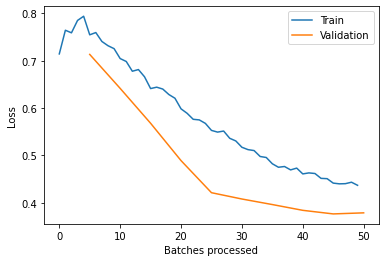

In [22]:
#inspect losses.
learn.recorder.plot_losses()

In [23]:
# unfreezing weights and training the rest of the NN
learn.freeze_to(-2)
learn.fit_one_cycle(4, slice(5e-3, 2e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.297645,0.340646,0.896104,05:48
1,0.337256,0.467849,0.818182,05:47
2,0.321763,0.393961,0.857143,05:46
3,0.303134,0.332301,0.883117,05:49


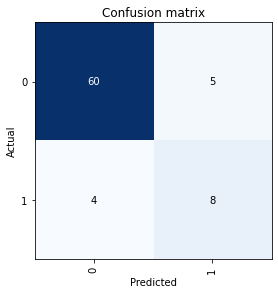

In [24]:
# create confusion matrix
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)
interp.plot_confusion_matrix()